### Train DNN

In [11]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
#from sklearn.model_selection import StratifiedKFold, KFold
#from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, TensorDataset, DataLoader
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import torch.nn.functional as F
import sys
module_path = Path().resolve().parents[1] / "src" / "models"

# Append the directory to sys.path
sys.path.append(str(module_path))


from trainDNN import *
from explainDNN import *
from predictDNN import *

module_path = Path().resolve().parents[1] / "src" / "postprocessing"

# Append the directory to sys.path
sys.path.append(str(module_path))


from getModelPerformance import *

#### Load features

In [12]:
feature_path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_CS_men_v2"
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labels.npy"))
lats = np.load(Path(feature_path / "numpy_lat.npy"))
lons = np.load(Path(feature_path / "numpy_lon.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)


In [13]:
features.shape[1]

139

In [14]:
features

array([[2.34354608e-01, 9.99990000e+04, 5.83295768e+04, ...,
        0.00000000e+00, 0.00000000e+00, 2.75000006e-01],
       [1.60412745e-01, 9.99990000e+04, 5.28133394e+04, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000007e-02],
       [9.81667696e-02, 9.99990000e+04, 8.34024000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000007e-02],
       ...,
       [1.26698812e+00, 1.36908578e+00, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000007e-02],
       [1.26698812e+00, 1.36908578e+00, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000007e-02],
       [1.26698812e+00, 1.36908578e+00, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000007e-02]])

#### Define the neural network architecture

In [15]:
loss_fn = torch.nn.MSELoss()

In [16]:
class DNN(torch.nn.Module):
    def __init__(self, layer_width):
        super(DNN, self).__init__()

        self.do_prob = 0.2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(features.shape[1], layer_width[0]),
            torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], layer_width[1]),
            torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[2]),
            torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[3]),
            torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[4]),
            torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[5]),
            torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[6]),
            torch.nn.BatchNorm1d(layer_width[6]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),

        )

        self.decoder = torch.nn.Sequential(
            # torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[6], layer_width[5]),
            #torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[4]),
            #torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[3]),
            #torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[2]),
            #torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[1]),
            #torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[0]),
            #torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], features.shape[1])
        )

        self.supervised = torch.nn.Sequential(
            torch.nn.Linear(layer_width[6], layer_width[7]),
            torch.nn.BatchNorm1d(layer_width[7]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[7], layer_width[8]),
            torch.nn.BatchNorm1d(layer_width[8]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[8], layer_width[9]),
            torch.nn.BatchNorm1d(layer_width[9]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[9], 1),

        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        targets = self.supervised(encoded)
        #return decoded, targets
        return targets
        
def initialize_weights(m):

    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)

"""
# torch.nn.Dropout(self.do_prob),
torch.nn.Linear(layer_width[6], layer_width[5]),
#torch.nn.BatchNorm1d(layer_width[5]),
torch.nn.ReLU(),
torch.nn.Dropout(self.do_prob),
torch.nn.Linear(layer_width[5], layer_width[4]),
#torch.nn.BatchNorm1d(layer_width[4]),
torch.nn.ReLU(),
torch.nn.Dropout(self.do_prob),
torch.nn.Linear(layer_width[4], layer_width[3]),
#torch.nn.BatchNorm1d(layer_width[3]),
torch.nn.ReLU(),
torch.nn.Dropout(self.do_prob),
torch.nn.Linear(layer_width[3], layer_width[2]),
#torch.nn.BatchNorm1d(layer_width[2]),
torch.nn.ReLU(),
torch.nn.Dropout(self.do_prob),
"""

'\n# torch.nn.Dropout(self.do_prob),\ntorch.nn.Linear(layer_width[6], layer_width[5]),\n#torch.nn.BatchNorm1d(layer_width[5]),\ntorch.nn.ReLU(),\ntorch.nn.Dropout(self.do_prob),\ntorch.nn.Linear(layer_width[5], layer_width[4]),\n#torch.nn.BatchNorm1d(layer_width[4]),\ntorch.nn.ReLU(),\ntorch.nn.Dropout(self.do_prob),\ntorch.nn.Linear(layer_width[4], layer_width[3]),\n#torch.nn.BatchNorm1d(layer_width[3]),\ntorch.nn.ReLU(),\ntorch.nn.Dropout(self.do_prob),\ntorch.nn.Linear(layer_width[3], layer_width[2]),\n#torch.nn.BatchNorm1d(layer_width[2]),\ntorch.nn.ReLU(),\ntorch.nn.Dropout(self.do_prob),\n'

In [17]:

layer_widths = [128, 128, 128, 128, 128, 128, 128, 128, 128, 128]  # Define your desired layer widthsmodel = DNN(layer_widths)#DNN(input_dim, layer_widths)
model = DNN(layer_widths)#DNN(input_dim, layer_widths)
model.apply(initialize_weights)
model.double()


DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [18]:
model = DNN(layer_widths)
model = model.double()
model.apply(initialize_weights)

torch.manual_seed(42)

In [ ]:
"""
#time intensive operation(better save processed features and labels, after first run)
features, labels, lats, lons = preprocess_features_labels(features, labels, lats, lons, X_mean, X_std) 
np.save("preprocessed/features_CS", features)
np.save("preprocessed/labels_CS", labels)
np.save("preprocessed/lats_CS", lats)
np.save("preprocessed/lons_CS", lons)

Duplicate row with index [1246 1247 1248] was in group 6 and was replaced with NaN values
Duplicate row with index [ 861 4326 4327] was in group 14 and was replaced with NaN values
Duplicate row with index [6525 6526 6529 6530 6531 6532] was in group 24 and was replaced with NaN values
Duplicate row with index [5579 5580 5581 5582 8625 8626 8627 8628 8629 8630 8631 8632 8633 8634
 8635 8636] was in group 45 and was replaced with NaN values
Duplicate row with index [6527 6528 6533 6534 6535 6536] was in group 96 and was replaced with NaN values
Duplicate row with index [8637 8638 8639 8640 8641 8642] was in group 117 and was replaced with NaN values
Duplicate row with index [665 666] was in group 129 and was replaced with NaN values
Duplicate row with index [ 855 4314] was in group 181 and was replaced with NaN values
Duplicate row with index [5360 5361 5597 5598 5599 5600 8563 8564] was in group 211 and was replaced with NaN values
Duplicate row with index [37358 37359 37360 37689 3769

In [ ]:
features = np.load("preprocessed/features_CS.npy")
labels = np.load("preprocessed/labels_CS.npy")

In [ ]:
features.shape

(14256, 139)

In [ ]:
features = torch.tensor(features)
labels = torch.tensor(labels)

In [45]:
trainloader, testloader = create_train_test_loader(features, labels, batch_size = 500, test_size_ratio=1/7, shuffle=True)

Train data size
13686
Test data size
570


In [46]:
"""
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
"""

'\nprint(f"Model structure: {model}\n\n")\n\nfor name, param in model.named_parameters():\n    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")\n'

In [47]:
# if there is a pretrained model, this can be used
"""
path = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_CS.pth"
state_dict = torch.load(path)
model.load_state_dict(state_dict)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else 
#print(physical_devices)
model.to(device)
model.double()
"""

'\npath = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_CS.pth"\nstate_dict = torch.load(path)\nmodel.load_state_dict(state_dict)\ndevice = torch.device(\'cuda:0\' if torch.cuda.is_available() else \'cpu\') #\'cuda:0\' if torch.cuda.is_available() else \n#print(physical_devices)\nmodel.to(device)\nmodel.double()\n'

In [48]:
# GPU intensive operation!!
num_epochs = 500
training_accuracy, training_losses, training_mae, learning_rate, evaluation_losses, evaluation_mae, true_labels, pred_labels =  train_model(model, loss_fn, trainloader, testloader, num_epochs = num_epochs)

epoch: 0 | Training Loss: 0.347 | MAE: 0.237 | LR: 0.0100000 |
epoch: 0 | Testing Loss: 0.428 | MAE: 0.225  |

epoch: 1 | Training Loss: 0.361 | MAE: 0.236 | LR: 0.0080000 |
epoch: 1 | Testing Loss: 0.162 | MAE: 0.196  |

epoch: 2 | Training Loss: 0.307 | MAE: 0.224 | LR: 0.0080000 |
epoch: 2 | Testing Loss: 0.122 | MAE: 0.175  |

epoch: 3 | Training Loss: 0.341 | MAE: 0.234 | LR: 0.0064000 |
epoch: 3 | Testing Loss: 0.333 | MAE: 0.209  |

epoch: 4 | Training Loss: 0.302 | MAE: 0.219 | LR: 0.0064000 |
epoch: 4 | Testing Loss: 0.148 | MAE: 0.174  |

epoch: 5 | Training Loss: 0.307 | MAE: 0.221 | LR: 0.0064000 |
epoch: 5 | Testing Loss: 0.151 | MAE: 0.187  |

epoch: 6 | Training Loss: 0.314 | MAE: 0.223 | LR: 0.0051200 |
epoch: 6 | Testing Loss: 0.157 | MAE: 0.181  |

epoch: 7 | Training Loss: 0.293 | MAE: 0.215 | LR: 0.0051200 |
epoch: 7 | Testing Loss: 0.121 | MAE: 0.170  |

epoch: 8 | Training Loss: 0.286 | MAE: 0.216 | LR: 0.0040960 |
epoch: 8 | Testing Loss: 0.115 | MAE: 0.156  |

e

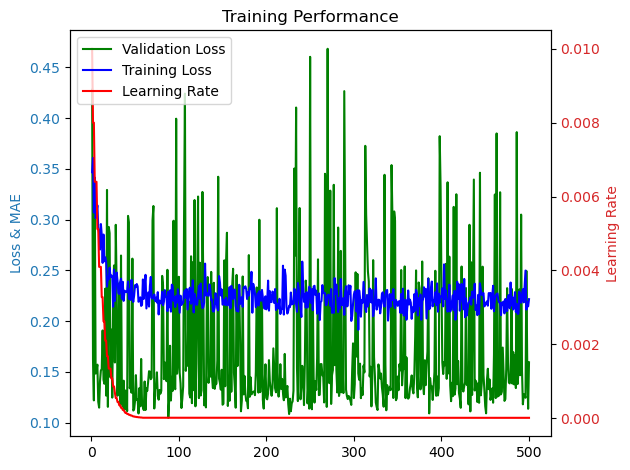

In [49]:
torch.manual_seed(42)
plot_model_performance(num_epochs,  evaluation_losses[-500:], training_losses[-500:], learning_rate[-500:])

In [52]:
output_path = Path().resolve().parents[1] / "data" / "output" / "scatterplots_TOC" / "scatter_plot_TOC_noconstraint_supervised_CS_men_test.png"
output_path = str(output_path)
test_labels, test_targets = evaluate_model(model, testloader, output_path)

(570,)
(570,)
correlation coefficient:
0.862557084887831
mae:
0.1769515308152277
mse:
0.16934761092736508
rmse:
0.4115186641300308


In [51]:

#lats = np.load("lats_CS.npy")
#lons = np.load("lons_CS.npy")
all_labels, all_targets =  evaluate_all_predictions(model, features, labels, output_path)


correlation coefficient:
0.9292226191333693
mae:
0.1610481062639618
mse:
0.17128032302012214
rmse:
0.41386026992225544


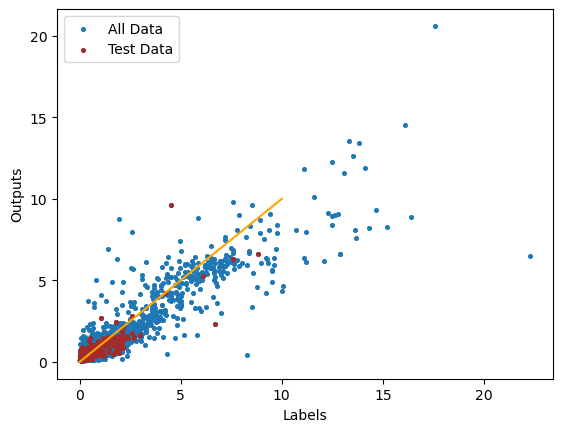

In [53]:
# Scatter plot with different colors for test labels and test targets
plt.scatter(all_labels, all_targets, label='All Data', s= 7)
plt.scatter(test_labels, test_targets, label='Test Data', color='brown', s=7)  # Add this line

line = np.linspace(0, 10, 100)

# Plot the reference line
plt.plot(line, line, 'orange')

# Set labels and title
plt.xlabel("Labels")
plt.ylabel("Outputs")

# Add legend
plt.legend()

In [69]:
#torch.save(model.state_dict(), path = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_CS.pth")

In [54]:
#"""
np.save("all_labels_NN_CS_v2", all_labels)
np.save("all_predictions_NN_CS_v2", all_targets)
np.save("test_labels_NN_CS_v2", test_labels)
np.save("test_predictions_NN_CS_v2", test_targets)
#"""

### Explain DNN using SHAP values (Find feature importance)

In [12]:

#should shuffle the indices again
features = np.load("preprocessed/features_CS.npy")
labels = np.load("preprocessed/labels_CS.npy")

import shap
import pandas as pd

# Convert the input features to a PyTorch tensor with the correct data type
features = torch.tensor(features, dtype=torch.float64)

if torch.cuda.is_available():
    features = features.cuda()

In [23]:
# GPU intensive operation!!!
explain_shap(model, features, feature_names=None, explainer_path='preprocessed/explainer_CS_v2.pkl', shap_values_path='preprocessed/shap_values_CS_v2.pkl', force_plot_index=0, summary_max_display=10)

In [13]:
#if the previous line has already been performed and the shap values are saved, only the following lines can be used.
with open('preprocessed/explainer_CS_v2.pkl', 'rb') as explainer_file:
    explainer = pickle.load(explainer_file)

with open('preprocessed/shap_values_CS_v2.pkl', 'rb') as shap_values_file:
    shap_values = pickle.load(shap_values_file)

In [14]:
features.shape

torch.Size([14256, 139])

In [15]:
shap_values.shape

(14256, 139)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


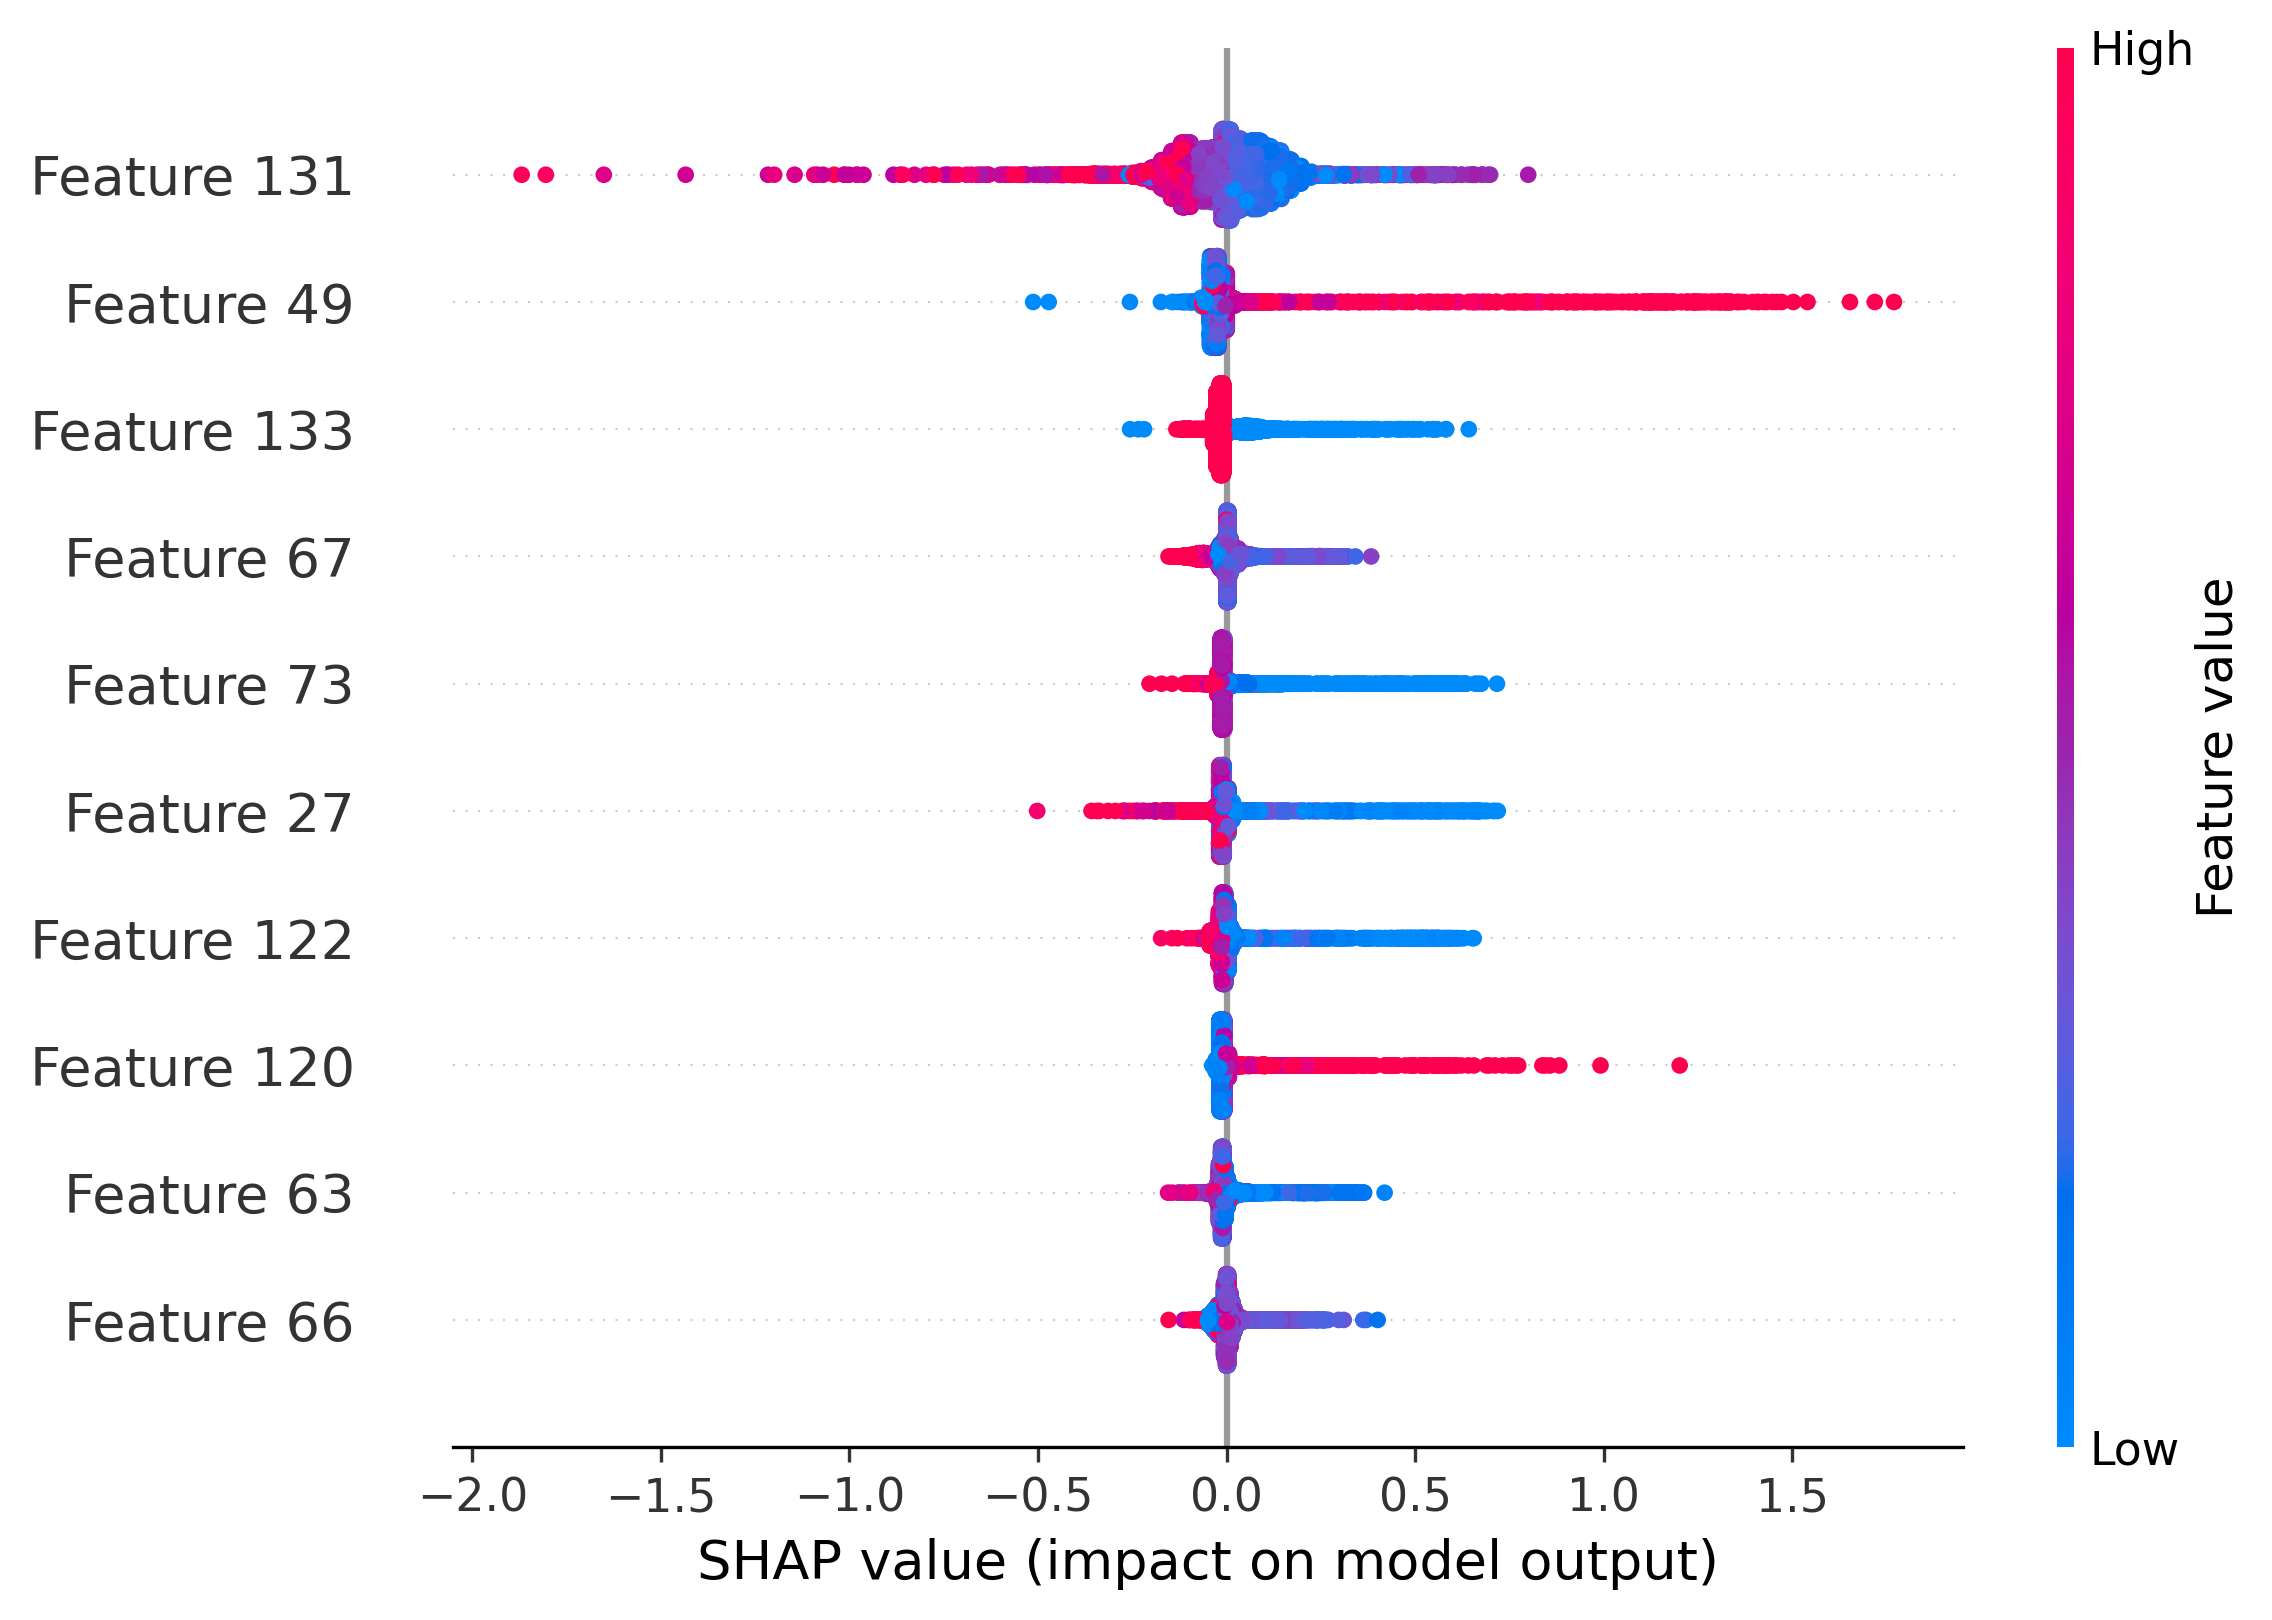

In [17]:
plt.figure(dpi=300)
shap.summary_plot(shap_values, features.cpu().numpy(), max_display=10)

In [16]:
feature_names = None
# Convert features and SHAP values to NumPy arrays
features_np = features#.cpu().detach().numpy()
shap_values_np = shap_values#[0]#.cpu().detach().numpy()
# Create a DataFrame for SHAP values
if feature_names is None:
    feature_names = [f'Feature {i}' for i in range(features_np.shape[1])]

shap_values_df = pd.DataFrame(shap_values_np, columns=feature_names)

# Calculate mean absolute SHAP value for each feature
feature_importance = shap_values_df.abs().mean().sort_values(ascending=False)

# Sort the SHAP values DataFrame by feature importance
shap_values_df_sorted = shap_values_df[feature_importance.index]


In [17]:
feature_importance.to_csv("feature_importance_CS")

### Predict using the trained DNN

In [1]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os
import gc
from os import walk  


feature_path = path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_CS_men_v2"
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)

dataset_path = Path().resolve().parents[1] / "data" / "interim" / "worldfeatures" / "WorldFeaturesAllnoNaN_SedTOC"

files = []

for (dirpath, dirnames, filenames) in walk(dataset_path):
    files.extend(filenames)
    break

files.sort()


features = np.load(Path(dataset_path / files[0]))
prediction_sum_save = Path().resolve().parents[1] / "data" / "interim" / "predictions" / "predictions_CS_v2"

In [22]:


model.eval()
enable_dropout(model) #for mc dropout


np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else 
#print(physical_devices)
model.to(device)
model.double()


DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [23]:
features = np.load(Path(dataset_path / files[0]))

chunk_shape = [6,4320] #360 chunks


first_run = True
ii = 0

for count, file in enumerate(files):
    #if count > 2:
    #    break
    features = np.load(Path(dataset_path / file))
    features = np.divide((features - X_mean), X_std)

    features = torch.tensor(features)
    features = features.to(device)

    # Perform multiple forward passes with dropout
    num_samples = 100  # number of monte carlo forward passes: gives us the number of predictions or the size of the prediction ensemble
    predictions_sum = np.zeros((num_samples, chunk_shape[0], chunk_shape[1]))

    with torch.no_grad():
        for i in range(num_samples):
            predictions = model(features)
         
            # Store predictions for later averaging
            predictions_sum[i] = predictions.cpu().detach().numpy().reshape(chunk_shape)

    # Average predictions over all samples
    predictions_avg = np.mean(predictions_sum, axis=0)
    predictions_var = np.var(predictions_sum, axis=0)
    save_path = os.path.join(prediction_sum_save , f'predictions_sum_{ii}.npy')
    np.save(save_path, predictions_sum)
    #fit_params, failed_fits, failed_fit_details = fit_gaussian_to_predictions(predictions_sum)
    #print(failed_fits)

    if first_run:
        prediction_map2 = predictions_avg
        prediction_map2_var = predictions_var
        first_run = False
    else:
        prediction_map2 = np.append(prediction_map2, predictions_avg, axis=0)
        prediction_map2_var = np.append(prediction_map2_var, predictions_var, axis=0)

    ii += 1
    print("Prediction " + str(ii) + " done!")

    del features
    gc.collect()
    


In [24]:
### GPU intensive operation!!
#prediction_map2, prediction_map2_var = perform_mc_dropout_prediction(model, dataset_path, prediction_sum_save, X_mean, X_std)

In [2]:
# We save the distributions or the monte carlo output for each chunk. Here we read all the distributions from different chunks and paste it together.
# Reading the distributions of all the chunks requires a lot of memory!!
# Requires high memory(RAM)(atleast 65 GB of RAM). Should probably be run on a CPU(prefereable a cluster) to get all the prediction distributions.
# UNCOMMENT IT TO PUT THE CHUNKS OF THE DISTRIBUTIONS TOGETHER
#"""
import os
import numpy as np

# Get a list of files in the directory and sort them
files_in_dir = sorted([f for f in os.listdir(prediction_sum_save) if f.endswith('.npy')], key=lambda x: int(x.split('_')[-1][:-4]))


failed_fits_all = []
i = 0
first_run = True

# Load and concatenate each predictions_sum array along the second axis
for file in files_in_dir:
    file_path = os.path.join(prediction_sum_save, file)
    predictions_sum = np.load(file_path)
    
    if first_run:
        prediction_map_dist = predictions_sum
        first_run = False
    else:
        # Concatenate along the second axis (axis=1)
        prediction_map_dist = np.concatenate((prediction_map_dist, predictions_sum), axis=1)
    i += 1
    print(i)
np.save(Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_dist_CS_v2", prediction_map_dist)
#"""

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [26]:
land_file = path = Path().resolve().parents[1] / "data" / "raw" / "island_map.npy"
land_map = np.load(land_file)
land_map[np.isnan(land_map)] = 1


In [27]:
import matplotlib.colors as mcolors
prediction_map2 = np.rot90(np.rot90(np.fliplr(prediction_map2)))
#prediction_map2[land_map] = 0

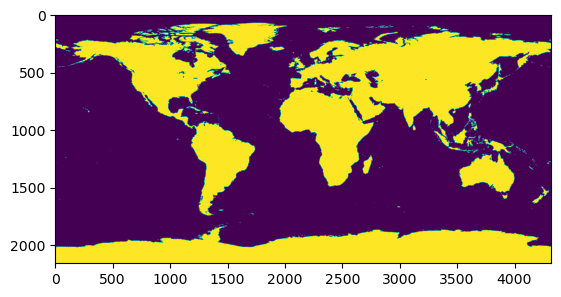

In [ ]:
plt.imshow(land_map)

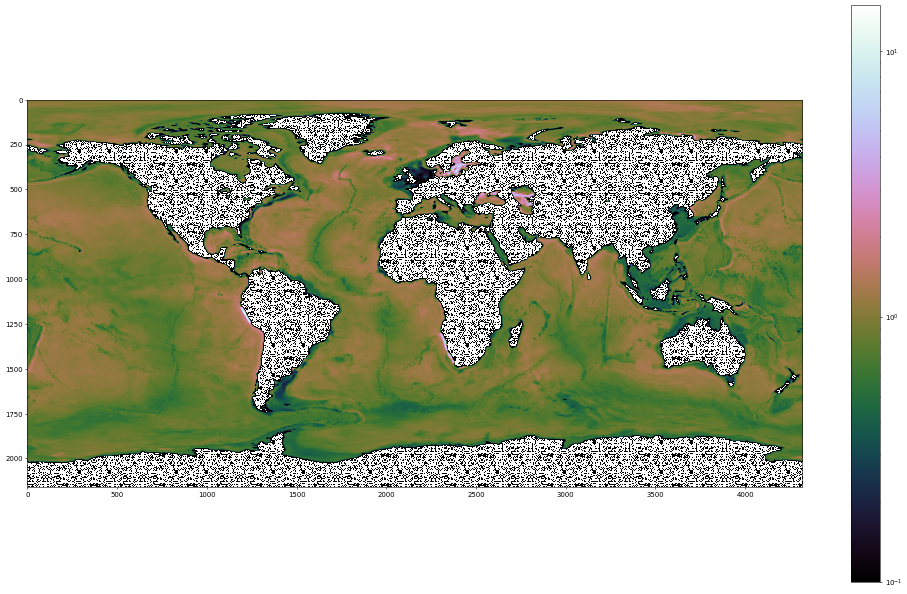

In [29]:
prediction_map2[land_map] = 0
plt.figure(figsize=[25, 15], dpi=50)
plt.imshow(prediction_map2, norm=mcolors.LogNorm(vmin=1e-1, vmax=15),cmap="cubehelix")
cbar = plt.colorbar()

In [43]:
np.save( Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_TOC_supervised_men_CS_noconstraint_v2.npy", prediction_map2)